Welcome to the PLRUN Checker. This is a feature to help you to get quick information for when you have a Pipeline running long.
You'll need the PLRUNSEQ for the BAD pipeline, and the PLRUNSEQ for the Good
Open your Prompt and type: cd C:\"Program Files"\SAP\hdbclient


Enter the HANA DB SERVER:  
Enter the HANA DB PORT:  
Enter the ADUSER:  


Than, type hdbuserstore -i SET hana_hxe “:” 
After you finish, press enter and, on the new row, set your AD Password


When you finish, press ENTER 


Now, let's work with your case info.


Enter the FOLDER NAME you want to create this ticket:  TEST2


Directory 'TEST2' created successfully.


Enter the BAD plrunseq:  
Enter the GOOD plrunseq:  
Enter the TENANTID:  
Enter the DATABASE:  


Starting the gathering PLRUN info
Step 1/10 - Starting the gathering Pipeline STAGES info
Step 2/10 - Starting the gathering Pipeline METRICS info
Step 3/10 - Starting the gathering Pipeline DEBUG info
Step 4/10 - Starting the gathering the ISLAND info for the Period
Step 5/10 - Starting the gathering the WORKSET info for the Period
Step 6/10 - Starting the gathering Pipeline MEMORY USAGE info
Step 8/10 - Starting the gathering the EXPENSIVE STATEMENT HASHES HISTORY that ran during the Pipeline runtimes info
Step 9/10 - Starting the gathering Pipeline overwall metrics
Step 10/10 - Starting the PL that ran in parallel
Step 11/10 - Starting the PL history for the same Period and PU
Step 12/10 - Creating all files and writting them into the folder
Step 13/10 - Process finished, and all files has been outputed. Process took 


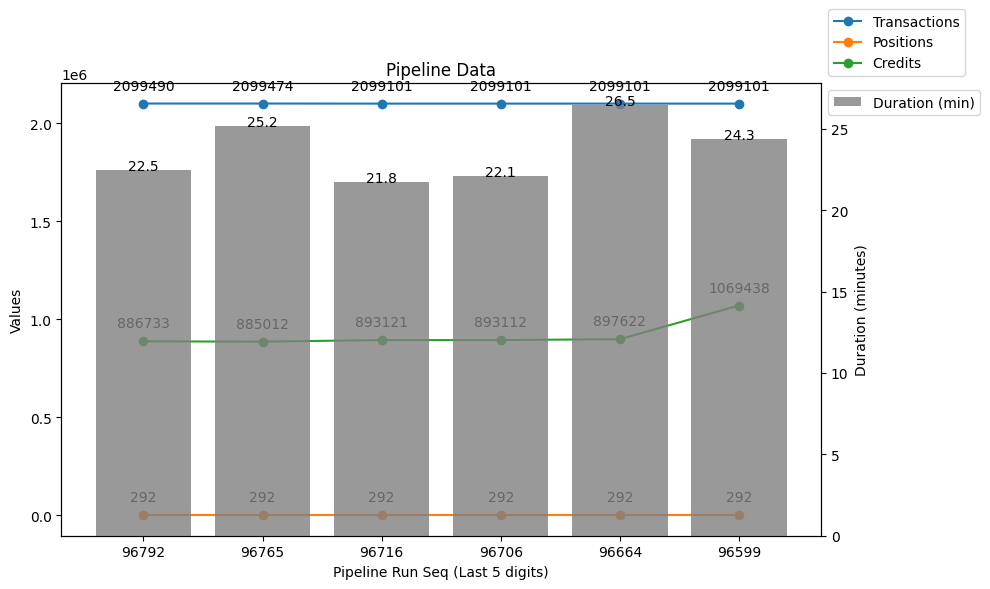

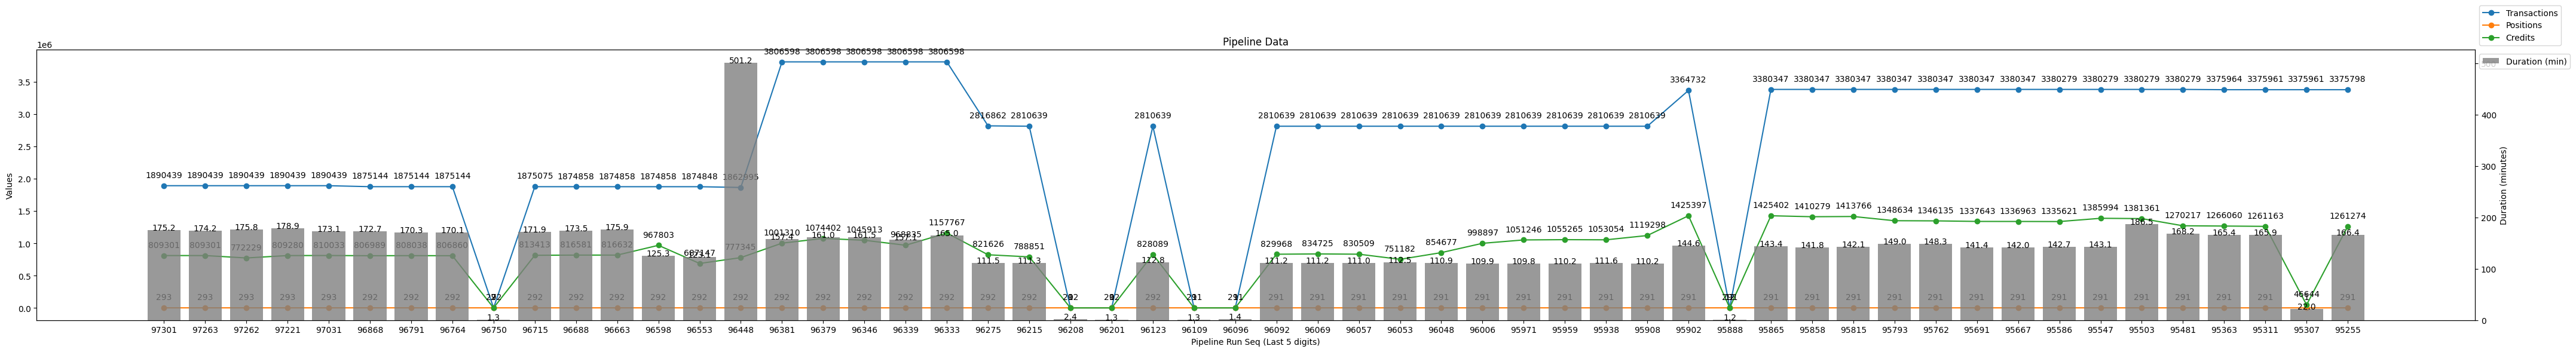

In [2]:
# Code retrieved from https://developers.sap.com/tutorials/hana-clients-python.html
#Must have HANADB Client installed
#Must Connect with secure password (see https://community.sap.com/t5/technology-blogs-by-sap/hands-on-tutorial-machine-learning-push-down-to-sap-hana-with-python/ba-p/13391657)
#Import your dependencies
import platform
from hdbcli import dbapi
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import import_ipynb
from ipynb.fs.full.Queries import *
from ipynb.fs.full.Funcoes import *

print("Welcome to the PLRUN Checker. This is a feature to help you to get quick information for when you have a Pipeline running long.")
print("You'll need the PLRUNSEQ for the BAD pipeline, and the PLRUNSEQ for the Good")

print('Open your Prompt and type: cd C:\\"Program Files"\\SAP\\hdbclient')

                            ### END SYSTEM WARNINGS ###

                            ### START SYSTEM INPUTS ###

SERVER =  input("Enter the HANA DB SERVER: ")
PORT =  input("Enter the HANA DB PORT: ")
ADUSER =  input("Enter the ADUSER: ")

print(f"Than, type hdbuserstore -i SET hana_hxe “{SERVER}:{PORT}” {ADUSER}")
print("After you finish, press enter and, on the new row, set your AD Password")

CONFIRM = input("When you finish, press ENTER")

print("Now, let's work with your case info.")

FOLDER_NAME = input("Enter the FOLDER NAME you want to create this ticket: ")
Innitial_current_timestamp = time.time()

try:
    os.makedirs(FOLDER_NAME)
    print(f"Directory '{FOLDER_NAME}' created successfully.")
except FileExistsError:
    print(f"Directory '{FOLDER_NAME}' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")
    
BAD =  input("Enter the BAD plrunseq: ") or '20547673299896448'
GOOD =  input("Enter the GOOD plrunseq: ") or '20547673299896664'
TENANTID =  input("Enter the TENANTID: ") or '0829'
DATABASE = input("Enter the DATABASE: ") or 'SMF0829PRD'
STEPS = 10
CURRENT_STEP = 1
                            ### END SYSTEM OUTPUTS ###

                            ### START DB CONNECTION ###

try :
    #Initialize your connection
    conn = dbapi.connect(
        key='hana_hxe', # address, port, user and password are retrieved from the hdbuserstore
        databasename = DATABASE
    )
except dbapi.Error as er:
    print('Connect failed, exiting')
    print(er)

                            ### END DB CONNECTION ###

                            ### START APPLICATION LOGIC ###

if(len(str(GOOD)) == 0):
    print("Pipeline running long usually requires a good and bad to compare. You need to provide one good, at least. Ask to customer")
    print("Exiting")
else:
    cursor = conn.cursor()

    
                            ### BEGGINING OF THE GOOD AND BAD PLRUN ###

    print("Starting the gathering PLRUN info")
    #FIRST, GET ALL INFO FROM THE GOOD PLRUN
    cursor.execute(get_pipeline_runseq(GOOD, TENANTID))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_PLRUN = pd.DataFrame(rows, columns=columns)
    GOOD_PLRUN['TOTAL_TIME'] = ((GOOD_PLRUN['STOPTIME'] - GOOD_PLRUN['STARTTIME']).dt.total_seconds()/60).round(2)
    #print(GOOD_PLRUN)
    #GOOD_PLRUN['TOTAL_TIME'] = calculate_minutes_between(GOOD_PLRUN['STARTTIME'].values[0], GOOD_PLRUN['STOPTIME'].values[0])


    #SECOND, GET ALL INFO FROM THE BAD PLRUN
    cursor.execute(get_pipeline_runseq(BAD, TENANTID))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_PLRUN = pd.DataFrame(rows, columns=columns)
    BAD_PLRUN['TOTAL_TIME'] = calculate_minutes_between(BAD_PLRUN['STARTTIME'].values[0], BAD_PLRUN['STOPTIME'].values[0])

                            ### END OF THE GOOD AND BAD PLRUN ###
    
                            ### BEGGINING OF THE GOOD AND BAD STAGERUNS ###

    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering Pipeline STAGES info")
    CURRENT_STEP = CURRENT_STEP+1
    #THIRD, LET'S GET THE ALL STAGES FROM THE GOOD AND BAD PIPELINE
    cursor.execute(get_pipeline_stage_runtime(GOOD_PLRUN['PIPELINERUNSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_STAGES = pd.DataFrame(rows, columns=columns)
    GOOD_STAGES['TOTAL_TIME'] = ((GOOD_STAGES['STOPTIME'] - GOOD_STAGES['STARTTIME']).dt.total_seconds()/60).round(2)

    cursor.execute(get_pipeline_stage_runtime(BAD_PLRUN['PIPELINERUNSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_STAGES = pd.DataFrame(rows, columns=columns)
    BAD_STAGES['TOTAL_TIME'] = ((BAD_STAGES['STOPTIME'] - BAD_STAGES['STARTTIME']).dt.total_seconds()/60).round(2)

                            ### END OF THE GOOD AND BAD STAGERUNS ###

                            ### BEGGINING OF THE GOOD AND BAD PIPELINE METRICS ###

    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering Pipeline METRICS info")
    CURRENT_STEP = CURRENT_STEP+1
    #FOURTH, GET THE ALLOCATE RUNTIMES, AND TOTAL OF TRANSACTIONS, POSITIONS, AND CREDITS
    cursor.execute(get_pipeline_allocate_runtime(GOOD_PLRUN['PIPELINERUNSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_METRICS = pd.DataFrame(rows, columns=columns)
    GOOD_METRICS['TOTAL_TIME'] = ((GOOD_METRICS['STOPTIME'] - GOOD_METRICS['STARTTIME']).dt.total_seconds()/60).round(2)

    cursor.execute(get_pipeline_allocate_runtime(BAD_PLRUN['PIPELINERUNSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_METRICS = pd.DataFrame(rows, columns=columns)
    BAD_METRICS['TOTAL_TIME'] = ((BAD_METRICS['STOPTIME'] - BAD_METRICS['STARTTIME']).dt.total_seconds()/60).round(2)

                            ### END OF THE GOOD AND BAD PIPELINE METRICS ###

                            ### BEGGINING OF THE GOOD AND BAD PIPELINE DEBUG ###
    
    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering Pipeline DEBUG info")
    CURRENT_STEP = CURRENT_STEP+1
    #FIFTH STEP, GET THE DEBUGS
    cursor.execute(get_debug(TENANTID, GOOD_PLRUN['STARTTIME'].values[0], GOOD_PLRUN['STOPTIME'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_DEBUG = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_debug(TENANTID, BAD_PLRUN['STARTTIME'].values[0], BAD_PLRUN['STOPTIME'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_DEBUG = pd.DataFrame(rows, columns=columns)

                        ### END OF THE GOOD AND BAD PIPELINE DEBUG ###

                        ### BEGGINING OF THE GOOD AND BAD ISLAND INFO ###

    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering the ISLAND info for the Period")
    CURRENT_STEP = CURRENT_STEP+1
    #SIXTH STEP, isLandNumber
    cursor.execute(get_isLand(GOOD_PLRUN['PERIODSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_ISLAND = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_isLand(BAD_PLRUN['PERIODSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_ISLAND = pd.DataFrame(rows, columns=columns)

                        ### END OF THE GOOD AND BAD ISLAND INFO ###

                        ### BEGGINING OF THE GOOD AND BAD WORKSET INFO ###
    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering the WORKSET info for the Period")
    CURRENT_STEP = CURRENT_STEP+1
    #SEVENTH STEP, workerSet
    cursor.execute(get_workSet(GOOD_PLRUN['PERIODSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_WORKSET = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_workSet(BAD_PLRUN['PERIODSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_WORKSET = pd.DataFrame(rows, columns=columns)

                        ### END OF THE GOOD AND BAD WORKSET INFO ###

                        ### BEGGINING OF THE GOOD AND BAD MEMORY USAGE INFO ###

    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering Pipeline MEMORY USAGE info")
    CURRENT_STEP = CURRENT_STEP+1
    #EIGHT get Memory Usage
    cursor.execute(get_MemoryUsage(GOOD_PLRUN['PIPELINERUNSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_MEMORY_USAGE = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_MemoryUsage(BAD_PLRUN['PIPELINERUNSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_MEMORY_USAGE = pd.DataFrame(rows, columns=columns)

                        ### END OF THE GOOD AND BAD MEMORY USAGE INFO ###

                        ### BEGGINING OF THE GOOD AND BAD EXPENSIVE STATEMENTS ###

    #print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering the EXPENSIVE STATEMENTS that ran during the Pipeline runtimes info")
    CURRENT_STEP = CURRENT_STEP+1
    #NINETH STEP, EXPENSIVE STATEMENT BETWEEN THE RUNTIMES
    cursor.execute(get_ExpensiveStatement(GOOD_PLRUN['STARTTIME'].values[0], GOOD_PLRUN['STOPTIME'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_EXPENSIVE_STATEMENT = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_ExpensiveStatement(BAD_PLRUN['STARTTIME'].values[0], BAD_PLRUN['STOPTIME'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_EXPENSIVE_STATEMENT = pd.DataFrame(rows, columns=columns)

                        ### END OF THE GOOD AND BAD EXPENSIVE STATEMENTS ###

                        ### BEGGINING OF THE GOOD AND BAD EXPENSIVE STATEMENTS HISTORY ###

    BAD_HASHES = format_column_values(BAD_EXPENSIVE_STATEMENT['STATEMENT_HASH'])
    GOOD_HASHES = format_column_values(GOOD_EXPENSIVE_STATEMENT['STATEMENT_HASH'])

    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering the EXPENSIVE STATEMENT HASHES HISTORY that ran during the Pipeline runtimes info")
    CURRENT_STEP = CURRENT_STEP+1
    #NINETH STEP, EXPENSIVE STATEMENT BETWEEN THE RUNTIMES
    #print(get_PreviousExpensiveStatementByStatement_Hash(GOOD_HASHES))
    cursor.execute(get_PreviousExpensiveStatementByStatement_Hash(GOOD_HASHES))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_EXPENSIVE_STATEMENT_HISTORY = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_PreviousExpensiveStatementByStatement_Hash(BAD_HASHES))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_EXPENSIVE_STATEMENT_HISTORY = pd.DataFrame(rows, columns=columns)

                        ### END OF THE GOOD AND BAD EXPENSIVE STATEMENTS HISTORY ###

                        ### BEGGINING OF THE GOOD AND BAD PIPELINE OVERWALL METRICS ###

    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the gathering Pipeline overwall metrics")
    CURRENT_STEP = CURRENT_STEP+1
    #get_PLRUN_Metrics
    cursor.execute(get_PLRUN_Metrics(GOOD_PLRUN['PIPELINERUNSEQ'].values[0], BAD_PLRUN['PIPELINERUNSEQ'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    PLRUN_METRICS = pd.DataFrame(rows, columns=columns)


                        ### END OF THE GOOD AND BAD PIPELINE OVERWALL METRICS ###

                        ### BEGGINING OF THE GOOD AND BAD PIPELINE THAT RAN IN PARALLEL ###

    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the PL that ran in parallel")
    CURRENT_STEP = CURRENT_STEP+1
    #EIGHT get Memory Usage
    cursor.execute(get_Parallel_Pipelines(GOOD_PLRUN['STARTTIME'].values[0], GOOD_PLRUN['STOPTIME'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_PLRUN_PARALLEL = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_Parallel_Pipelines(BAD_PLRUN['STARTTIME'].values[0], BAD_PLRUN['STOPTIME'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_PLRUN_PARALLEL = pd.DataFrame(rows, columns=columns)  
                        ### END OF THE GOOD AND BAD PIPELINE THAT RAN IN PARALLEL ###

                        ### BEGIN OF THE GOOD AND BAD STAGES FOR THE SAME PERIOD ###
    print(f"Step {CURRENT_STEP}/{STEPS} - Starting the PL history for the same Period and PU")
    CURRENT_STEP = CURRENT_STEP+1
    cursor.execute(
        get_pipeline_runseqs_same_period_same_PU(
            GOOD_PLRUN['PERIODSEQ'].values[0],
            GOOD_PLRUN['RUNMODE'].values[0],
            GOOD_PLRUN['STAGETYPESEQ'].values[0],
            GOOD_PLRUN['PROCESSINGUNITSEQ'].values[0],
            GOOD_PLRUN['TRACELEVEL'].values[0],
            TENANTID
        )
    )
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    SIMILAR_GOOD_PL_SAME_PERIOD_SAME_PU = pd.DataFrame(rows, columns=columns)

    cursor.execute(get_ExpensiveStatement(BAD_PLRUN['STARTTIME'].values[0], BAD_PLRUN['STOPTIME'].values[0]))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    cursor.execute(
        get_pipeline_runseqs_same_period_same_PU(
            BAD_PLRUN['PERIODSEQ'].values[0],
            BAD_PLRUN['RUNMODE'].values[0],
            BAD_PLRUN['STAGETYPESEQ'].values[0],
            BAD_PLRUN['PROCESSINGUNITSEQ'].values[0],
            BAD_PLRUN['TRACELEVEL'].values[0],
            TENANTID
        )
    )
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    SIMILAR_BAD_PL_SAME_PERIOD_SAME_PU = pd.DataFrame(rows, columns=columns)

    GOOD_SIMILAR_PL_SAME_PERIOD_SAME_PU = format_column_values(SIMILAR_GOOD_PL_SAME_PERIOD_SAME_PU['PIPELINERUNSEQ'])
    BAD_SIMILAR_PL_SAME_PERIOD_SAME_PU = format_column_values(SIMILAR_BAD_PL_SAME_PERIOD_SAME_PU['PIPELINERUNSEQ'])

    #get_hist_stage_runtimes
    cursor.execute(get_hist_stage_runtimes(GOOD_SIMILAR_PL_SAME_PERIOD_SAME_PU))
    rows = cursor.fetchall()
    #plot_pipeline_data(GOOD_SIMILAR_SAME_PERIOD_SAME_PU)
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    GOOD_SIMILAR_SAME_PERIOD_SAME_PU = pd.DataFrame(rows, columns=columns) 
    
    #get_hist_stage_runtimes
    cursor.execute(get_hist_stage_runtimes(BAD_SIMILAR_PL_SAME_PERIOD_SAME_PU))
    rows = cursor.fetchall()
    # Get column names from the cursor description
    columns = [column[0] for column in cursor.description]
    BAD_SIMILAR_SAME_PERIOD_SAME_PU = pd.DataFrame(rows, columns=columns)

                        ### END OF THE GOOD AND BAD OTHER PLRUN FOR THE SAME PU AND PERIOD ###

                                   ### OUTPUT FILES ###
    
    print(f"Step {CURRENT_STEP}/{STEPS} - Creating all files and writting them into the folder")
    CURRENT_STEP = CURRENT_STEP+1
    #LAST STEP, THE OUTPUTS
    GOOD_PLRUN.to_csv(f'{FOLDER_NAME}/1_GOOD_PLRUN.txt', index=False, sep='\t')
    BAD_PLRUN.to_csv(f'{FOLDER_NAME}/1_BAD_PLRUN.txt', index=False, sep='\t')

    GOOD_STAGES.to_csv(f'{FOLDER_NAME}/2_GOOD_STAGES.txt', index=False, sep='\t')
    BAD_STAGES.to_csv(f'{FOLDER_NAME}/2_BAD_STAGES.txt', index=False, sep='\t')

    GOOD_METRICS.to_csv(f'{FOLDER_NAME}/3_GOOD_METRICS.txt', index=False, sep='\t')
    BAD_METRICS.to_csv(f'{FOLDER_NAME}/3_BAD_METRICS.txt', index=False, sep='\t')

    GOOD_DEBUG.to_csv(f'{FOLDER_NAME}/4_GOOD_DEBUG.txt', index=False, sep='\t')
    BAD_DEBUG.to_csv(f'{FOLDER_NAME}/4_BAD_DEBUG.txt', index=False, sep='\t')

    GOOD_ISLAND.to_csv(f'{FOLDER_NAME}/8_GOOD_ISLAND.txt', index=False, sep='\t')
    BAD_ISLAND.to_csv(f'{FOLDER_NAME}/8_BAD_ISLAND.txt', index=False, sep='\t')

    GOOD_WORKSET.to_csv(f'{FOLDER_NAME}/7_GOOD_WORKSET.txt', index=False, sep='\t')
    BAD_WORKSET.to_csv(f'{FOLDER_NAME}/7_BAD_WORKSET.txt', index=False, sep='\t')

    GOOD_MEMORY_USAGE.to_csv(f'{FOLDER_NAME}/5_GOOD_MEMORY_USAGE.txt', index=False, sep='\t')
    BAD_MEMORY_USAGE.to_csv(f'{FOLDER_NAME}/5_BAD_MEMORY_USAGE.txt', index=False, sep='\t')

    GOOD_EXPENSIVE_STATEMENT.to_csv(f'{FOLDER_NAME}/6_GOOD_EXPENSIVE_STATEMENT.txt', index=False, sep='\t')
    BAD_EXPENSIVE_STATEMENT.to_csv(f'{FOLDER_NAME}/6_BAD_EXPENSIVE_STATEMENT.txt', index=False, sep='\t')

    GOOD_PLRUN_PARALLEL.to_csv(f'{FOLDER_NAME}/1_GOOD_PLRUN_IN_PARALLEL.txt', index=False, sep='\t')
    BAD_PLRUN_PARALLEL.to_csv(f'{FOLDER_NAME}/1_BAD_PLRUN_IN_PARALLEL.txt', index=False, sep='\t')

    GOOD_EXPENSIVE_STATEMENT_HISTORY.to_csv(f'{FOLDER_NAME}/6_GOOD_EXPENSIVE_STATEMENT_HISTORY.txt', index=False, sep='\t')
    BAD_EXPENSIVE_STATEMENT_HISTORY.to_csv(f'{FOLDER_NAME}/6_BAD_EXPENSIVE_STATEMENT_HISTORY.txt', index=False, sep='\t')

    plot_pipeline_same_pu(GOOD_SIMILAR_SAME_PERIOD_SAME_PU, FOLDER_NAME, 'GOOD_PL_SAME_PERIOD_SAME_PU')
    plot_pipeline_same_pu(BAD_SIMILAR_SAME_PERIOD_SAME_PU, FOLDER_NAME, 'BAD_PL_SAME_PERIOD_SAME_PU')

    PLRUN_METRICS.to_csv(f'{FOLDER_NAME}/1_PLRUN_METRICS.txt', index=False, sep='\t')
    
    Final_current_timestamp = time.time()    
    
    print(f"Step {CURRENT_STEP}/{STEPS} - Process finished, and all files has been outputed. Process took ")
